In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Function
import numpy as np
from torch.cuda.amp import autocast, GradScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# ✅ 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Binary Weight Quantizer (STE)
class BinaryWeightQuantizer(Function):
    @staticmethod
    def forward(ctx, input):
        return input.sign()
    
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.clone()

# ✅ Binary Activation (STE)
class BinaryActivation(Function):
    @staticmethod
    def forward(ctx, input):
        return input.sign()
    
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.clone()

# ✅ QAT용 Binary Conv/Linear 레이어
class QATBinaryConv2d(nn.Conv2d):
    def forward(self, input):
        binary_weight = BinaryWeightQuantizer.apply(self.weight)
        return F.conv2d(input, binary_weight, None, self.stride, self.padding, self.dilation, self.groups)

class QATBinaryLinear(nn.Linear):
    def forward(self, input):
        binary_weight = BinaryWeightQuantizer.apply(self.weight)
        return F.linear(input, binary_weight, self.bias)

def threshold_activation(x, threshold):
    """
    x: torch.Tensor, shape (N, C) or (N, C, H, W)
    threshold: numpy.ndarray, shape (C,)
    """
    th = torch.from_numpy(threshold).to(x.device)

    # 차원에 따라 shape broadcast
    if x.dim() == 4:
        # (N, C, H, W) → th: (1, C, 1, 1)
        th = th.view(1, -1, 1, 1)
    elif x.dim() == 2:
        # (N, C) → th: (1, C)
        th = th.view(1, -1)
    else:
        raise ValueError(f"Unsupported input shape: {x.shape}")

    return (x > th).float() * 2 - 1

# ✅ 전체 QAT BNN 모델
class QATBNN(nn.Module):
    def __init__(self):
        super(QATBNN, self).__init__()
        self.conv1 = QATBinaryConv2d(1, 16, 3, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = QATBinaryConv2d(16, 32, 3, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = QATBinaryConv2d(32, 32, 3, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(32)

        self.pool = nn.AvgPool2d(2)

        self.bn_fc = nn.BatchNorm1d(3872)  # ✅ FC 입력을 위한 1D BN
        self.fc1 = QATBinaryLinear(3872, 10)

    def forward(self, x):
        x = (x > 0.5).float() * 2 - 1
        
        x = self.conv1(x)
        #x = self.bn1(x)
        x = BinaryActivation.apply(x)

        x = self.conv2(x)
        #x = self.bn2(x)
        x = BinaryActivation.apply(x)

        x = self.conv3(x)
        #x = self.bn3(x)
        x = BinaryActivation.apply(x)

        x = self.pool(x)
        x = torch.flatten(x, 1)

        #x = self.bn_fc(x)                 # ✅ flatten 이후에 BN
        x = BinaryActivation.apply(x)     # ✅ 1bit 이진화 (training)
        x = self.fc1(x)

        return F.log_softmax(x, dim=1)

In [9]:
# ✅ 데이터 로더
batch_size = 1024 
workers = 4
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size,num_workers=workers)

# ✅ 학습 루프
model = QATBNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)

torch.backends.cudnn.benchmark = True
model = model.to(device)
scaler = GradScaler()

conv1_threashold = 0; conv2_threashold = 0; conv3_threashold = 0
train_acc_lst = []; val_acc_lst = []; train_loss_lst = []; val_loss_lst = []

if __name__ == "__main__":
    best_acc = 0
    for epoch in range(20):
        model.train()
        train_loss = 0
        train_correct = 0

        for data, target in train_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            optimizer.zero_grad()
            with autocast():
                output = model(data)
                loss = F.nll_loss(output, target)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1)
            train_correct += pred.eq(target).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset) * 100
        
        train_acc_lst.append(train_acc); train_loss_lst.append(train_loss)

        # ✅ 평가 루프 (float 기준 정확도)
        model.eval()
        val_loss = 0
        val_correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += F.nll_loss(output, target, reduction='sum').item()
                pred = output.argmax(dim=1)
                val_correct += pred.eq(target).sum().item()

        val_loss /= len(test_loader.dataset)
        val_acc = val_correct / len(test_loader.dataset) * 100
        if val_acc > best_acc:
            best_acc = val_acc
            if best_acc > 93 :
                torch.save(model.state_dict(), "qat_bnn_model.pth")  # ✅ 가장 좋은 모델 저장
        val_acc_lst.append(val_acc); val_loss_lst.append(val_loss)

        print(f"Epoch {epoch+1:2d}: Train Loss {train_loss:.4f}, Acc {train_acc:.2f}% | Val Acc {val_acc:.2f}% | Best Val Acc {best_acc:.2f}%") #Val Loss {val_loss:.4f}, 

    print(f"Best Validation Accuracy: {best_acc:.2f}%")

Epoch  1: Train Loss 40.4711, Acc 35.78% | Val Acc 66.46% | Best Val Acc 66.46%
Epoch  2: Train Loss 11.8152, Acc 71.60% | Val Acc 78.84% | Best Val Acc 78.84%
Epoch  3: Train Loss 8.7645, Acc 78.70% | Val Acc 82.94% | Best Val Acc 82.94%
Epoch  4: Train Loss 6.3531, Acc 83.38% | Val Acc 85.29% | Best Val Acc 85.29%
Epoch  5: Train Loss 5.4788, Acc 85.12% | Val Acc 83.45% | Best Val Acc 85.29%
Epoch  6: Train Loss 5.1582, Acc 85.91% | Val Acc 85.68% | Best Val Acc 85.68%
Epoch  7: Train Loss 4.8880, Acc 86.79% | Val Acc 88.37% | Best Val Acc 88.37%
Epoch  8: Train Loss 4.4223, Acc 87.79% | Val Acc 82.80% | Best Val Acc 88.37%
Epoch  9: Train Loss 4.4585, Acc 87.85% | Val Acc 86.41% | Best Val Acc 88.37%
Epoch 10: Train Loss 4.3024, Acc 88.18% | Val Acc 88.29% | Best Val Acc 88.37%
Epoch 11: Train Loss 4.2146, Acc 88.68% | Val Acc 88.80% | Best Val Acc 88.80%
Epoch 12: Train Loss 4.5265, Acc 88.06% | Val Acc 89.04% | Best Val Acc 89.04%
Epoch 13: Train Loss 4.4686, Acc 88.40% | Val Acc 

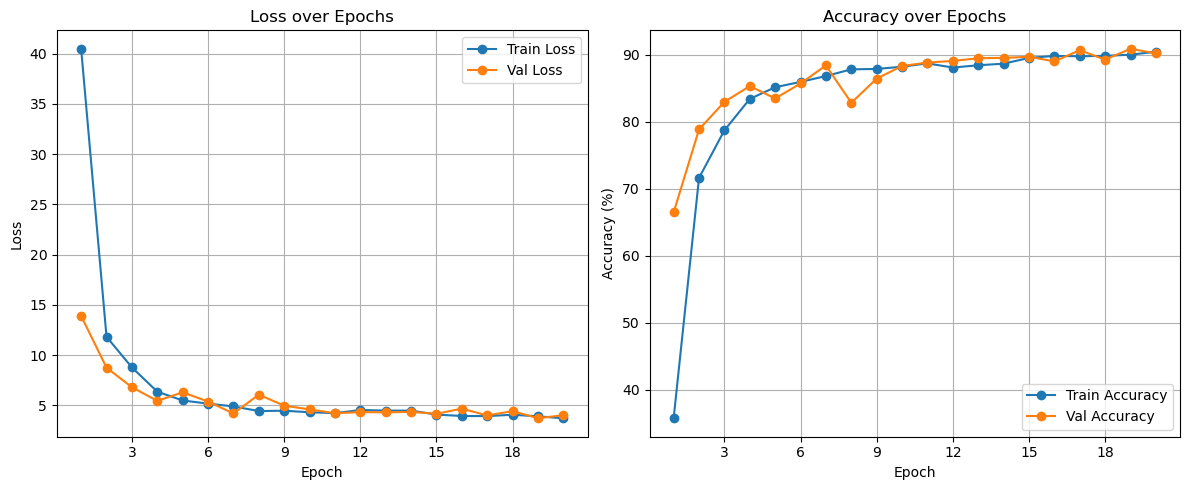

In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator  # ✅ 정수 눈금 전용

# ✅ Epoch 리스트
epochs = range(1, len(train_loss_lst) + 1)

# ✅ 그래프 그리기
plt.figure(figsize=(12, 5))

# 🔹 1. Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_lst, label='Train Loss', marker='o')
plt.plot(epochs, val_loss_lst, label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # ✅ x축 정수

# 🔹 2. Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_lst, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc_lst, label='Val Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # ✅ x축 정수

plt.tight_layout()
plt.show()
